In [1]:
import pandas as pd
import numpy as np
from impyute.imputation.cs import fast_knn
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter('ignore')

In [2]:
df = pd.read_excel('NAFLD with FIB4 and NFS Scores.xlsx').drop(294)
df.head()

,Patient No.,Age,"Gender (Female=1, Male=2)",Height,Weight,Body Mass Index,Waist Circumference,Hip Circumference,Systolic Blood Pressure,Diastolic Blood Pressure,...,NAS score according to Kleiner,"NAS score>=4 and Fibrosis>=2 (If NAS score>=4 and Fibrosis>=2 = 1, If not = 0)","Fibrosis status (No=0, Yes=1) (Fibrosis 1 and above, there is Fibrosis)","Significant Fibrosis (No=0, Yes=1) (If Fibrosis 2 and above, there is Significant Fibrosis)","Advanced Fibrosis (No=0, Yes=1) (If Fibrosis is 3 and above, there is Advanced Fibrosis)","Cirrhosis (No=0, Yes=1) (If Fibrosis is 4, there is Cirrhosis)","Diagnosis according to SAF (NASH=1, NAFL=2)","Type of Disease (Mild illness=1, Severe illness=2)",FIB-4,NFS
0,1,60,1,150,80,35.56,119.0,104.0,135,77,...,4,1,1,0,0,0,1,2,1.066491,-0.557850
1,2,55,1,154,73,30.78,101.0,98.0,120,72,...,4,1,0,0,0,0,1,2,0.801388,-2.290680
2,3,53,2,170,101,34.95,116.0,112.0,120,80,...,4,1,1,1,1,0,1,2,1.532768,-0.647403
3,4,33,2,175,95,31.02,114.0,114.0,124,83,...,4,1,1,0,0,0,1,2,0.352520,-3.661870
4,5,23,2,162,68,25.91,101.0,97.0,124,79,...,4,1,0,0,0,0,1,2,0.490765,-3.995284


In [3]:
X = pd.concat([df.iloc[:,1:-13], df[['FIB-4', 'NFS']]], axis=1)
X = X.drop(['Height', 'Weight'], axis=1)
X.head()

,Age,"Gender (Female=1, Male=2)",Body Mass Index,Waist Circumference,Hip Circumference,Systolic Blood Pressure,Diastolic Blood Pressure,"Diyabetes Mellitus (No=0, Yes=1)","Hypertension (No=0, Yes=1)","Hyperlipidemia (No=0, Yes=1)",...,Glucose,Insulin,HOMA,"Insulin resistance according to HOMA (insulin resistance = 1, no insulin resistance = 2)",Uric Acid,BUN,Creatinine,Hemoglobin - A1C,FIB-4,NFS
0,60,1,35.56,119.0,104.0,135,77,0,1,1,...,119.0,29.2,8.58,1.0,NaN,12.0,0.58,NaN,1.066491,-0.557850
1,55,1,30.78,101.0,98.0,120,72,0,0,0,...,NaN,NaN,NaN,NaN,NaN,18.0,0.63,NaN,0.801388,-2.290680
2,53,2,34.95,116.0,112.0,120,80,1,1,1,...,93.0,NaN,NaN,NaN,NaN,NaN,NaN,4.70,1.532768,-0.647403
3,33,2,31.02,114.0,114.0,124,83,1,0,1,...,90.0,23.0,5.11,1.0,6.57,20.0,0.73,4.70,0.352520,-3.661870
4,23,2,25.91,101.0,97.0,124,79,0,0,0,...,89.0,NaN,NaN,NaN,NaN,NaN,NaN,4.82,0.490765,-3.995284


In [4]:
adv_fib_y = pd.DataFrame(df.iloc[:, -6])
adv_fib_y.rename(columns={'Advanced Fibrosis (No=0, Yes=1) (If Fibrosis is 3 and above, there is Advanced Fibrosis)': 'Advanced Fibrosis'}, inplace=True)
adv_fib_y.head()

,Advanced Fibrosis
0,0
1,0
2,1
3,0
4,0


In [5]:
X_columns_1 = X.isna().sum().sort_values(ascending=False)[-18:].index   # features with no missing values
X_columns_2 = X.isna().sum().sort_values(ascending=False)[15:].index    # features <= 25% missing values threshold
X_baseline_1 = X[X_columns_1]   # Data Frame of features with no missing values
X_baseline_2 = X[X_columns_2]   # Data Frame of features with <= 25% missing values threshold

In [6]:
X_baseline_1.head()

,Systolic Blood Pressure,Diastolic Blood Pressure,"Hyperlipidemia (No=0, Yes=1)","Gender (Female=1, Male=2)","Diyabetes Mellitus (No=0, Yes=1)","Hypertension (No=0, Yes=1)",Body Mass Index,NFS,"Metabolic syndrome (No=0, Yes=1)",AST,ALT,Albumin,Total Cholesterol,FIB-4,Leukocyte,Hemoglobin,Trombosit,Age
0,135,77,1,1,0,1,35.56,-0.557850,0,27.0,49,5.0,170,1.066491,7300.0,12.7,217.0,60
1,120,72,0,1,0,0,30.78,-2.290680,0,17.0,18,4.4,170,0.801388,6000.0,12.9,275.0,55
2,120,80,1,2,1,1,34.95,-0.647403,1,51.0,74,5.1,190,1.532768,7700.0,13.5,205.0,53
3,124,83,1,2,1,0,31.02,-3.661870,1,31.0,72,4.9,199,0.352520,7300.0,15.1,342.0,33
4,124,79,0,2,0,0,25.91,-3.995284,0,32.0,51,5.3,211,0.490765,7000.0,17.4,210.0,23


In [7]:
X_baseline_2.head()

,Total Protein,LDH,Hemoglobin - A1C,Waist Circumference,"Smoking Status (Never Smoked=1, Left Smoking=2, Smoking=3)",Ferritin,Mean Platelet Volume,Hip Circumference,Glucose,GGT,...,"Metabolic syndrome (No=0, Yes=1)",AST,ALT,Albumin,Total Cholesterol,FIB-4,Leukocyte,Hemoglobin,Trombosit,Age
0,7.7,281.0,NaN,119.0,2.0,524.0,9.2,104.0,119.0,19.0,...,0,27.0,49,5.0,170,1.066491,7300.0,12.7,217.0,60
1,7.2,219.0,NaN,101.0,1.0,41.3,8.1,98.0,NaN,20.0,...,0,17.0,18,4.4,170,0.801388,6000.0,12.9,275.0,55
2,8.4,263.0,4.70,116.0,2.0,294.0,9.3,112.0,93.0,53.0,...,1,51.0,74,5.1,190,1.532768,7700.0,13.5,205.0,53
3,7.6,166.0,4.70,114.0,2.0,46.0,7.1,114.0,90.0,49.0,...,1,31.0,72,4.9,199,0.352520,7300.0,15.1,342.0,33
4,7.9,376.0,4.82,101.0,2.0,158.0,7.4,97.0,89.0,34.0,...,0,32.0,51,5.3,211,0.490765,7000.0,17.4,210.0,23


In [8]:
X_baseline_2 = fast_knn(X_baseline_2, k=30)
X_baseline_2.columns=X_columns_2

In [9]:
X_baseline_2.head()

,Total Protein,LDH,Hemoglobin - A1C,Waist Circumference,"Smoking Status (Never Smoked=1, Left Smoking=2, Smoking=3)",Ferritin,Mean Platelet Volume,Hip Circumference,Glucose,GGT,...,"Metabolic syndrome (No=0, Yes=1)",AST,ALT,Albumin,Total Cholesterol,FIB-4,Leukocyte,Hemoglobin,Trombosit,Age
0,7.7,281.0,5.815853,119.0,2.0,524.0,9.2,104.0,119.000000,19.0,...,0.0,27.0,49.0,5.0,170.0,1.066491,7300.0,12.7,217.0,60.0
1,7.2,219.0,6.108322,101.0,1.0,41.3,8.1,98.0,115.116432,20.0,...,0.0,17.0,18.0,4.4,170.0,0.801388,6000.0,12.9,275.0,55.0
2,8.4,263.0,4.700000,116.0,2.0,294.0,9.3,112.0,93.000000,53.0,...,1.0,51.0,74.0,5.1,190.0,1.532768,7700.0,13.5,205.0,53.0
3,7.6,166.0,4.700000,114.0,2.0,46.0,7.1,114.0,90.000000,49.0,...,1.0,31.0,72.0,4.9,199.0,0.352520,7300.0,15.1,342.0,33.0
4,7.9,376.0,4.820000,101.0,2.0,158.0,7.4,97.0,89.000000,34.0,...,0.0,32.0,51.0,5.3,211.0,0.490765,7000.0,17.4,210.0,23.0


In [10]:
sc = StandardScaler()
std_baseline_1 = sc.fit_transform(X_baseline_1)
std_baseline_2 = sc.fit_transform(X_baseline_2)
X_baseline_1 = pd.DataFrame(std_baseline_1, dtype=float, columns=X_columns_1)
X_baseline_2 = pd.DataFrame(std_baseline_2, dtype=float, columns=X_columns_2)

In [11]:
X_baseline_1.head()

,Systolic Blood Pressure,Diastolic Blood Pressure,"Hyperlipidemia (No=0, Yes=1)","Gender (Female=1, Male=2)","Diyabetes Mellitus (No=0, Yes=1)","Hypertension (No=0, Yes=1)",Body Mass Index,NFS,"Metabolic syndrome (No=0, Yes=1)",AST,ALT,Albumin,Total Cholesterol,FIB-4,Leukocyte,Hemoglobin,Trombosit,Age
0,0.502800,-0.547214,0.851889,-1.061490,-0.770498,1.349974,0.723837,0.794616,-1.359800,-0.718511,-0.556472,0.870652,-0.819515,-0.181490,0.027015,-0.946054,-0.366855,1.286731
1,-0.478537,-1.050438,-1.173862,-1.061490,-0.770498,-0.740755,-0.212371,-0.287782,-1.359800,-1.049117,-1.183843,-0.714021,-0.819515,-0.527666,-0.657913,-0.829162,0.486793,0.817075
2,-0.478537,-0.245280,0.851889,0.942072,1.297861,1.349974,0.604363,0.738678,0.735402,0.074945,-0.050527,1.134764,-0.406044,0.427381,0.237762,-0.478485,-0.543472,0.629213
3,-0.216847,0.056654,0.851889,0.942072,1.297861,-0.740755,-0.165365,-1.144284,0.735402,-0.586268,-0.091003,0.606540,-0.219982,-1.113805,0.027015,0.456654,1.472904,-1.249407
4,-0.216847,-0.345925,-1.173862,0.942072,-0.770498,-0.740755,-1.166207,-1.352548,-1.359800,-0.553208,-0.515996,1.662989,0.028101,-0.933282,-0.131045,1.800917,-0.469882,-2.188717


In [12]:
X_baseline_2.head()

,Total Protein,LDH,Hemoglobin - A1C,Waist Circumference,"Smoking Status (Never Smoked=1, Left Smoking=2, Smoking=3)",Ferritin,Mean Platelet Volume,Hip Circumference,Glucose,GGT,...,"Metabolic syndrome (No=0, Yes=1)",AST,ALT,Albumin,Total Cholesterol,FIB-4,Leukocyte,Hemoglobin,Trombosit,Age
0,-0.181771,0.360247,-0.201799,0.923824,0.388650,3.300175,0.321730,-0.028785,0.329947,-0.730958,...,-1.359800,-0.718511,-0.556472,0.870652,-0.819515,-0.181490,0.027015,-0.946054,-0.366855,1.286731
1,-1.348418,-0.321789,0.098032,-0.816965,-0.974075,-0.728207,-0.539995,-0.609996,0.203690,-0.716365,...,-1.359800,-1.049117,-1.183843,-0.714021,-0.819515,-0.527666,-0.657913,-0.829162,0.486793,0.817075
2,1.451535,0.162236,-1.345741,0.633692,0.388650,1.380706,0.400069,0.746161,-0.515323,-0.234810,...,0.735402,0.074945,-0.050527,1.134764,-0.406044,0.427381,0.237762,-0.478485,-0.543472,0.629213
3,-0.415101,-0.904819,-1.345741,0.440271,0.388650,-0.688983,-1.323381,0.939898,-0.612854,-0.293180,...,0.735402,-0.586268,-0.091003,0.606540,-0.219982,-1.113805,0.027015,0.456654,1.472904,-1.249407
4,0.284888,1.405301,-1.222720,-0.816965,0.388650,0.245715,-1.088365,-0.706864,-0.645365,-0.512069,...,-1.359800,-0.553208,-0.515996,1.662989,0.028101,-0.933282,-0.131045,1.800917,-0.469882,-2.188717


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import json
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_baseline_1, adv_fib_y, random_state=0, test_size=0.2, stratify=adv_fib_y)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_baseline_2, adv_fib_y, random_state=0, test_size=0.2, stratify=adv_fib_y)

In [14]:
def tune_params(model, param_grid, X_train, y_train):
    gridsearch_CV = GridSearchCV(model, param_grid, cv=10, n_jobs=-1)
    gridsearch_CV.fit(X_train, y_train)
    return gridsearch_CV.best_params_

In [ ]:
# lr_param_grid = {'C': np.logspace(-4, 4, 20), 'penalty': ['l1', 'l2'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
# best_lr_0 = tune_params(LogisticRegression(), lr_param_grid, X_train_0, y_train_0)
# best_lr_1 = tune_params(LogisticRegression(), lr_param_grid, X_train_1, y_train_1)
# lr_params = {}
# with open('lr_tuned_params.json', 'w') as file:
#     lr_params['tuned_lr_0'] = best_lr_0
#     lr_params['tuned_lr_25'] = best_lr_1
#     json.dump(lr_params, file)

In [ ]:
# rf_param_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)], 
#                  'max_features': ['auto', 'sqrt', 'log2'], 
#                  'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
#                  'criterion': ['gini', 'entropy'],
#                  'min_samples_split': [2, 5, 10],
#                  'min_samples_leaf': [1, 2, 4],
#                  'bootstrap': [True, False]}
# best_rf_0 = tune_params(RandomForestClassifier(), rf_param_grid, X_train_0, y_train_0)
# best_rf_1 = tune_params(RandomForestClassifier(), rf_param_grid, X_train_1, y_train_1)
# rf_params = {}
# with open('rf_tuned_params.json', 'w') as file:
#     rf_params['tuned_rf_0'] = best_rf_0
#     rf_params['tuned_rf_25'] = best_rf_1
#     json.dump(rf_params, file)

In [ ]:
# bagging_param_grid = {'max_samples' : [0.05, 0.1, 0.2, 0.5, 1.0, 5.0, 10.0],
#                       'max_features': [0.001, 0.05, 0.2, 0.5, 1.0, 5.0, 10.0], 
#                       'n_estimators': [10, 100, 200, 500, 1000]}
# best_bagging_0 = tune_params(BaggingClassifier(), bagging_param_grid, X_train_0, y_train_0)
# best_bagging_1 = tune_params(BaggingClassifier(), bagging_param_grid, X_train_1, y_train_1)
# bagging_params = {}
# with open('bagging_tuned_params.json', 'w') as file:
#     bagging_params['tuned_bagging_0'] = best_bagging_0
#     bagging_params['tuned_bagging_25'] = best_bagging_1
#     json.dump(bagging_params, file)
# print('done')

In [ ]:
# svm_param_grid = {'C': [1,10,100,1000], 'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf', 'sigmoid']}
# best_svm_0 = tune_params(SVC(probability=True), svm_param_grid, X_train_0, y_train_0)
# best_svm_1 = tune_params(SVC(probability=True), svm_param_grid, X_train_1, y_train_1)
# svm_params = {}
# with open('svm_tuned_params.json', 'w') as file:
#     svm_params['tuned_svm_0'] = best_svm_0
#     svm_params['tuned_svm_25'] = best_svm_1
#     json.dump(svm_params, file)

In [39]:
def read_json():
    my_dict = {}
    models = ['rf', 'bagging', 'lr', 'svm']
    for model in models:
        with open('%s_tuned_params.json' % model, 'r') as file:
            file = json.loads(file.read())
            for key in file:
                my_dict[key] = file[key]
    return my_dict
tuned_params = read_json()
print(tuned_params)

{'tuned_svm_0': {'kernel': 'rbf', 'C': 1, 'gamma': 0.1}, 'tuned_rf_0': {'n_estimators': 200, 'criterion': 'entropy', 'min_samples_split': 5, 'max_depth': 90, 'max_features': 'sqrt', 'bootstrap': False, 'min_samples_leaf': 2}, 'tuned_lr_0': {'penalty': 'l2', 'solver': 'newton-cg', 'C': 0.03359818286283781}, 'tuned_svm_25': {'kernel': 'rbf', 'C': 10, 'gamma': 0.001}, 'tuned_bagging_0': {'max_samples': 0.1, 'n_estimators': 200}, 'tuned_rf_25': {'n_estimators': 200, 'criterion': 'gini', 'min_samples_split': 5, 'max_depth': 30, 'max_features': 'auto', 'bootstrap': True, 'min_samples_leaf': 1}, 'tuned_bagging_25': {'max_samples': 0.5, 'n_estimators': 1000}, 'tuned_lr_25': {'penalty': 'l2', 'solver': 'newton-cg', 'C': 0.08858667904100823}}


In [40]:
lr_params_0 = tuned_params['tuned_lr_0']
lr_params_1 = tuned_params['tuned_lr_25']
lr_0 = LogisticRegression(C=lr_params_0['C'], penalty=lr_params_0['penalty'], solver=lr_params_0['solver'])
lr_1 = LogisticRegression(C=lr_params_1['C'], penalty=lr_params_1['penalty'], solver=lr_params_1['solver'])

In [41]:
svm_params_0 = tuned_params['tuned_svm_0']
svm_params_1 = tuned_params['tuned_svm_25']
svm_0 = SVC(probability=True, C=svm_params_0['C'], gamma=svm_params_0['gamma'], kernel=svm_params_0['kernel'])
svm_1 = SVC(probability=True, C=svm_params_1['C'], gamma=svm_params_0['gamma'], kernel=svm_params_1['kernel'])

In [42]:
rf_params_0 = tuned_params['tuned_rf_0']
rf_params_1 = tuned_params['tuned_rf_25']
rf_0 = RandomForestClassifier(criterion=rf_params_0['criterion'], max_depth=rf_params_0['max_depth'], max_features=rf_params_0['max_features'], n_estimators=rf_params_0['n_estimators'], min_samples_split=rf_params_0['min_samples_split'], bootstrap=rf_params_0['bootstrap'], min_samples_leaf=rf_params_0['min_samples_leaf'])
rf_1 = RandomForestClassifier(criterion=rf_params_1['criterion'], max_depth=rf_params_1['max_depth'], max_features=rf_params_1['max_features'], n_estimators=rf_params_1['n_estimators'], min_samples_split=rf_params_1['min_samples_split'], bootstrap=rf_params_1['bootstrap'], min_samples_leaf=rf_params_1['min_samples_leaf'])

In [43]:
bagging_params_0 = tuned_params['tuned_bagging_0']
bagging_params_1 = tuned_params['tuned_bagging_25']
bagging_0 = BaggingClassifier(max_samples=bagging_params_0['max_samples'], n_estimators=bagging_params_0['n_estimators'])
bagging_1 = BaggingClassifier(max_samples=bagging_params_1['max_samples'], n_estimators=bagging_params_1['n_estimators'])

In [44]:
def get_metrics(clf, X, y, label):
    metrics_ = {'auc_score': [], 'sensitivity': [], 'specificity': [], 'fn': [], 'fp': [], 'ppv': [], 'npv': [], 'plr': [], 'nlr': []}
    skf = StratifiedKFold(n_splits=10, random_state=0)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index, :], y.iloc[test_index, :]
        clf.fit(X_train, y_train)
        y_prob = clf.predict_proba(X_test)
        y_pred = clf.predict(X_test)        
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        metrics_['auc_score'].append(roc_auc_score(y_test, y_prob[:, 1]))
        sensitivity = tp / (tp + fn)    # also called recall and true positive rate
        specificity = tn / (tn + fp)    # also called true negative rate
        metrics_['sensitivity'].append(sensitivity)
        metrics_['specificity'].append(specificity)
        metrics_['fn'].append(fn / len(y_test))
        metrics_['fp'].append(fp / len(y_test))
        metrics_['ppv'].append(tp / (tp + fp))    # also called precision
        metrics_['npv'].append(tn / (tn + fn))
        metrics_['plr'].append(sensitivity / (1 - specificity))
        metrics_['nlr'].append((1 - sensitivity) / specificity)
    avg_auc_score = round(np.nanmean(metrics_['auc_score']), 3)
    avg_sensitivity = round(np.nanmean(metrics_['sensitivity']) * 100, 0)
    avg_specificity = round(np.nanmean(metrics_['specificity']) * 100, 0)
    avg_fn = round(np.nanmean(metrics_['fn']), 3)
    avg_fp = round(np.nanmean(metrics_['fp']), 3)
    avg_ppv = round(np.nanmean(metrics_['ppv']), 3)
    avg_npv = round(np.nanmean(metrics_['npv']), 3)
    plr = pd.DataFrame(metrics_['plr'])
    plr = plr.replace(np.inf, np.nan)
    nlr = pd.DataFrame(metrics_['nlr'])
    nlr = nlr.replace(np.inf, np.nan)
    avg_plr = round(np.nanmean(plr), 3)
    avg_nlr = round(np.nanmean(nlr), 3)
    return ['NA', label, avg_sensitivity, avg_specificity, avg_fn, avg_fp, avg_ppv, avg_npv, avg_plr, avg_nlr, avg_auc_score]

In [45]:
log_reg_metrics_0 = get_metrics(lr_0, X_baseline_1, adv_fib_y, 'LR 0 missing')
svm_metrics_0 = get_metrics(svm_0, X_baseline_1, adv_fib_y, 'SVM 0 missing')
rf_metrics_0 = get_metrics(rf_0, X_baseline_1, adv_fib_y, 'RF 0 missing')
bagging_metrics_0 = get_metrics(bagging_0, X_baseline_1, adv_fib_y, 'Bagging 0 missing')
log_reg_metrics_1 = get_metrics(lr_1, X_baseline_2, adv_fib_y, 'LR 25% missing')
svm_metrics_1 = get_metrics(svm_1, X_baseline_2, adv_fib_y, 'SVM 25% missing')
rf_metrics_1 = get_metrics(rf_1, X_baseline_2, adv_fib_y, 'RF 25% missing')
bagging_metrics_1 = get_metrics(bagging_1, X_baseline_2, adv_fib_y, 'Bagging 25% missing')

In [46]:
methods_metrics = np.array([['FIB-4 <1.3', 'NA', '64', '74', '0.358', '0.262', '0.342', '0.907', '2.452', '0.485', '0.731'], 
                         ['FIB-4 >2.67', 'NA', '15', '97', '0.852', '0.029', '0.522', '0.843', '5.145', '0.877', '0.731'],
                         ['NFS <-1.455', 'NA', '71', '63', '0.284', '0.369', '0.291', '0.913', '1.940', '0.450', '0.715'],
                         ['NFS >0.676', 'NA', '15', '96', '0.852', '0.037', '0.462', '0.842', '4.042', '0.884', '0.715'],
                         log_reg_metrics_0, svm_metrics_0, rf_metrics_0, bagging_metrics_0,
                         log_reg_metrics_1, svm_metrics_1, rf_metrics_1, bagging_metrics_1])

table_df = pd.DataFrame(methods_metrics, columns=['Cutoff', 'Classifier', 'Sensitivity %', 'Specificity %', 'FN',
                                                  'FP', 'PPV', 'NPV', 'PLR', 'NLR', 'AUC'])
table_df

,Cutoff,Classifier,Sensitivity %,Specificity %,FN,FP,PPV,NPV,PLR,NLR,AUC
0,FIB-4 <1.3,NA,64,74,0.358,0.262,0.342,0.907,2.452,0.485,0.731
1,FIB-4 >2.67,NA,15,97,0.852,0.029,0.522,0.843,5.145,0.877,0.731
2,NFS <-1.455,NA,71,63,0.284,0.369,0.291,0.913,1.940,0.450,0.715
3,NFS >0.676,NA,15,96,0.852,0.037,0.462,0.842,4.042,0.884,0.715
4,NA,LR 0 missing,18.0,97.0,0.147,0.025,0.492,0.844,7.415,0.851,0.777
5,NA,SVM 0 missing,13.0,98.0,0.156,0.013,0.677,0.839,3.712,0.887,0.757
6,NA,RF 0 missing,26.0,96.0,0.132,0.035,0.604,0.856,5.638,0.774,0.777
7,NA,Bagging 0 missing,19.0,97.0,0.146,0.027,0.533,0.845,7.332,0.842,0.784
8,NA,LR 25% missing,27.0,96.0,0.131,0.033,0.537,0.859,4.676,0.761,0.787
9,NA,SVM 25% missing,3.0,98.0,0.174,0.015,0.321,0.823,0.297,0.99,0.76


In [48]:
import matplotlib.pyplot as plt

In [49]:
def get_feature_importance(rf_model, X_train, y_train, df, fig_size):
    plt.figure(figsize=fig_size)
    features = df.columns
    rf = rf_model
    rf.fit(X_train, y_train)
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    values = [round(i,5) for i in importances[indices]]
    rects = plt.barh(features[indices][::-1], values[::-1])
    plt.title('Feature Importance Scores by RF')
    for i, v in enumerate(values[::-1]):
        plt.text(v + .0001, i, str(round(v, 4)))
    plt.show()

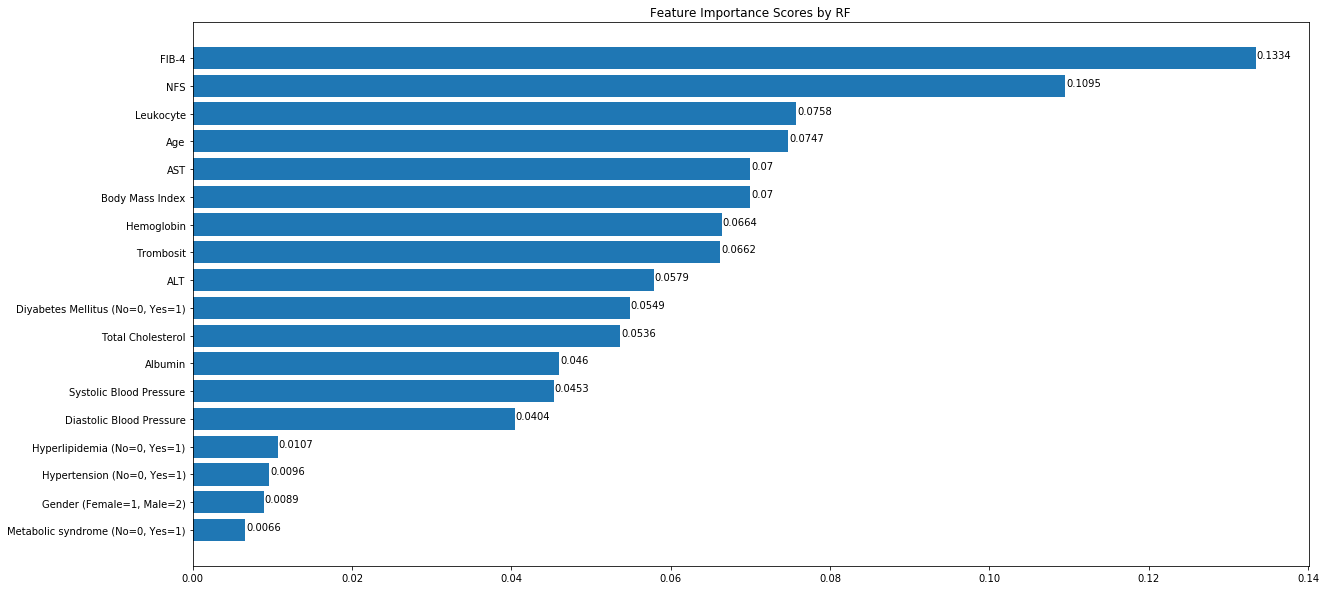

In [50]:
get_feature_importance(rf_0, X_train_0, y_train_0, X_baseline_1, (20, 10))

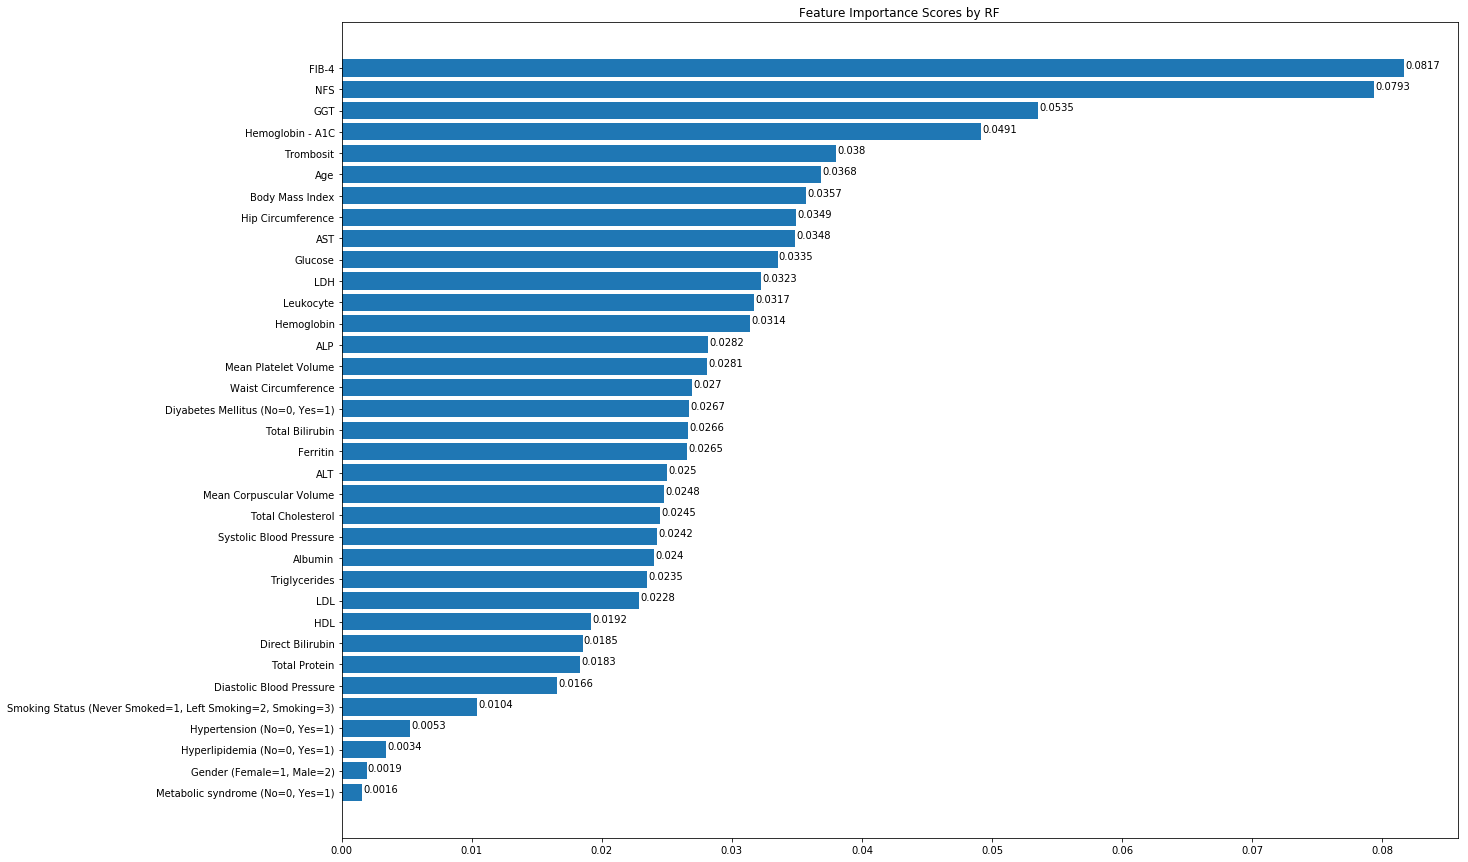

In [51]:
get_feature_importance(rf_1, X_train_1, y_train_1, X_baseline_2, (20, 15))